In [1]:
import numpy as np
import sys
#sys.path.append('/home/yungdankblast/Desktop/Research/delay-optimizer')
sys.path.append('/home/cayjobla/Desktop/Research/delay-optimizer')
from DelayEffects.Analyzer_new import FuncOpt
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.lines import Line2D
from Optimizer_Scripts.DelayTypeGenerators import *

# <center> Plots

In [2]:
# Initialize
dimensions = [2, 10, 100, 1000]
ack = {d:FuncOpt('Ackley', d) for d in dimensions}
rast = {d:FuncOpt('Rastrigin', d) for d in dimensions}
rosen = {d:FuncOpt('Rosenbrock', d) for d in dimensions}
zak = {d:FuncOpt('Zakharov', d) for d in dimensions}

### Helper Functions

In [3]:
def load_vals(func_dict, file_tags):
    if type(file_tags) == str:
        file_tags = {d:file_tags for d in dimensions}
    loss_name = func_dict[dimensions[0]].loss_name
    filenames = {d:f'Data/{loss_name}{d}d_{file_tags[d]}.npz' for d in dimensions}
    for d, func_obj in func_dict.items():
        func_obj.load(filenames[d])          # Load data into object
        
def unload(func_dict):
    for d, func_obj in func_dict.items():
        func_obj.reset()

# Bar Charts

In [4]:
def calc_mean(func_obj, delay_type, param_type='optimal', param_file='../final_params.csv'):
    func_obj.optimize(delay_type, break_opt=True, save_state=False, save_loss=True, 
                      save_grad=False, save_iters=False, param_type=param_type, 
                      param_file=param_file)
    print(func_obj.lr_params)
    return func_obj.get_mean_final(func_obj.loss_vals)

def compute_all(func_dict, delay_list, filename, param_type='optimal', param_file='../final_params.csv'):
    # Compute mean loss for each dimension and delay type
    means = {d:[] for d in dimensions}
    for d in dimensions:
        for delay_type in delay_list:
            means[d].append(calc_mean(func_dict[d], delay_type, param_type, param_file))
            func_dict[d].delete_data()

    np.save(filename, means, allow_pickle=True)    # Save values
    
    return means

def bar_chart(func_dict, delay_list, filename, param_type='optimal', param_file='../final_params.csv', **kwargs):
    # Load or compute mean values
    if os.path.exists(filename):
        means = np.load(filename, allow_pickle=True).item()
    else:
        means = compute_all(func_dict, delay_list, filename, param_type, param_file)
    
    # Initialize
    fig = plt.figure(figsize=(20, 4), dpi=300)
    axes = fig.subplots(1, 4).flatten()
    loss_name = func_dict[dimensions[0]].loss_name
    width = 0.35
    colors = ['C1', 'C0', 'C2', 'C3', 'C4']
    colors2 = ['lightblue', 'lightgreen', 'lightcoral', 'thistle']
    
    for i, d in enumerate(dimensions):
        axes[i].bar([width/2], [means[d][0]], width, color=[colors[0]], edgecolor='k')
        axes[i].bar(np.arange(1,5), means[d][1:5], width, color=colors[1:], edgecolor='k')
        axes[i].bar(np.arange(1,5) + width, means[d][5:], width, color=colors2, edgecolor='k')
        axes[i].set_title(loss_name + " " + str(d) + "d", fontsize=14)
        labels = ["Undelayed", "Uniform", "Decaying", "Stochastic", "Partial"]
        axes[i].set_xticks(np.arange(5) + width/2)
        axes[i].set_xticklabels(labels, rotation=30)
        
        if 'logscale' in kwargs and kwargs['logscale'] is True:
            axes[i].set_ylim([1e-8, max(means[d])*10])
            axes[i].set_yscale('log')
        if 'clip_axis' in kwargs and kwargs['clip_axis'] is True:
            undel_ratio = 2/3
            axes[i].set_ylim([0, means[d][0] / undel_ratio])
            
    fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)

In [5]:
L = 1
delay_list = [Undelayed(), Uniform(L, 2000), Decaying(L, 2000), Stochastic(L, 2000), Partial(L, 2000, p=0.5),
              Uniform(L, 1000), Decaying(L, 1000), Stochastic(L, 1000), Partial(L, 1000, p=0.5)]

In [6]:
def load(loss_name, d, file_tag):
    filename = f"Data/{loss_name}{d}d_{file_tag}.npz"
    
    # Load and extract necessary data
    data = np.load(filename, allow_pickle=True)     
    loss_name = str(data["loss_name"])
    n = int(data["n"])
    optimizer_name = str(data["optimizer_name"])
    maxiter = int(data["maxiter"])
    tol = float(data["tol"])
    del data
    
    # Load data into object
    func_obj = FuncOpt(loss_name=loss_name, n=n, optimizer_name=optimizer_name, maxiter=maxiter, tol=tol)
    func_obj.load(filename)
    
    return func_obj


def get_mean_final_loss(loss_name, d, file_tag):
    func_obj = load(loss_name, d, file_tag)
    return func_obj.get_mean_final(func_obj.loss_vals)


def plot_bar(loss_name, file_tags, delay_names=None, logscale=False, clip_axis=False):
    # Initialize
    fig = plt.figure(figsize=(20, 4), dpi=300)
    axes = fig.subplots(1, 4).flatten()
    colors = ['C1', 'C0', 'C2', 'C3', 'C4']
    
    for i, d in enumerate(dimensions):
        mean_final_losses = [get_mean_final_loss(loss_name, d, tag) for tag in file_tags]
        print(mean_final_losses)
        
        xticks = np.arange(len(mean_final_losses))
        axes[i].bar(xticks, mean_final_losses, color=colors, edgecolor='k')
        axes[i].set_title(f"{loss_name} {d}d", fontsize=14)
        axes[i].set_xticks(xticks)
        
        if delay_names is not None:
            axes[i].set_xticklabels(delay_names, rotation=30)
        
        if logscale is True:
            axes[i].set_ylim([1e-8, max(means[d])*10])
            axes[i].set_yscale('log')
            
        if clip_axis is True:
            undel_ratio = 2/3
            axes[i].set_ylim([0, means[d][0] / undel_ratio])
            
    fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
    return axes

## Ackley

[18.31088816241461, 8.111917118587769, 11.14048751504593]
[19.504091998113118, 8.617940727838397, 7.880326593073943]
[19.550839150659353, 6.298818665016628, 4.850851768839027]
[19.54293433172906, 5.362837395752304, 3.872412034104446]


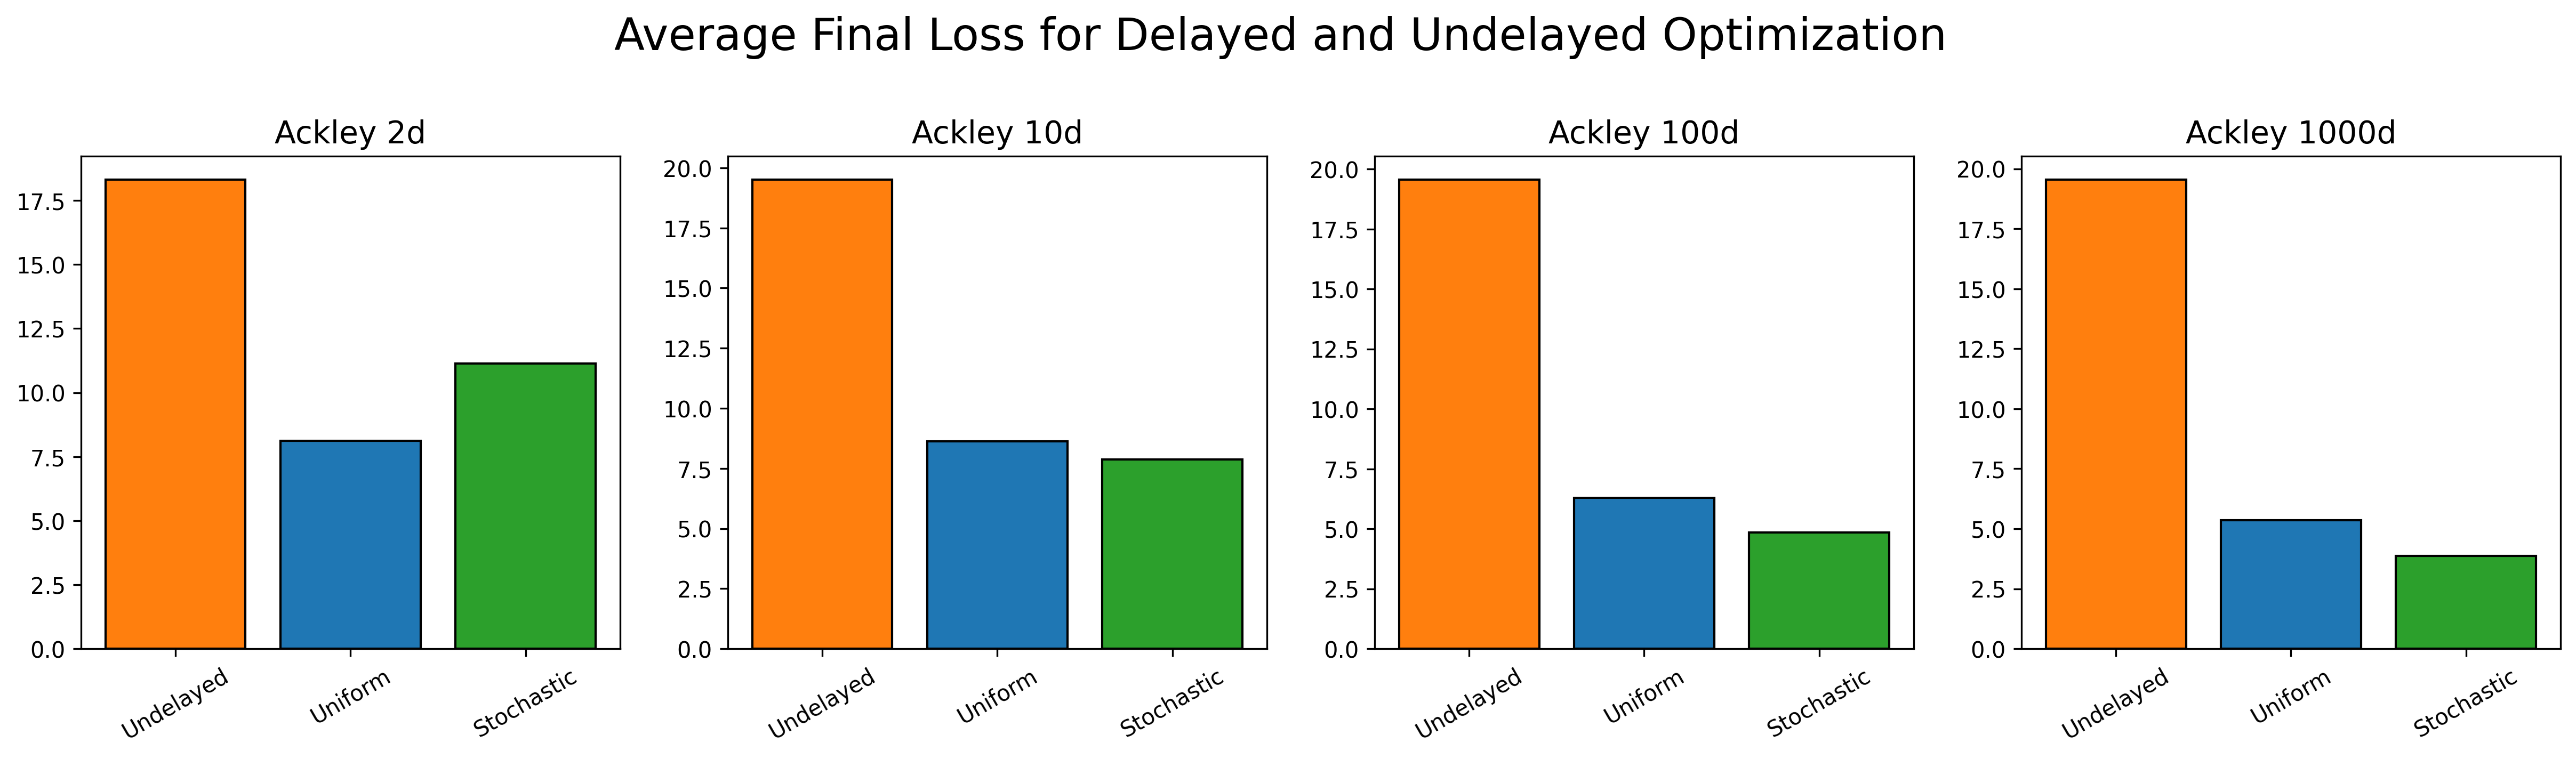

In [8]:
file_tags = ["optimal_undel", "undelayed_unif_full", "optimal_stoch"]
plot_bar("Ackley", file_tags, delay_names=["Undelayed", "Uniform", "Stochastic"])
plt.show()

## Rastrigin

In [2]:
file_tags = ["optimal_undel", "optimal_stoch"]
plot_bar("Ackley", file_tags, delay_names=["Undelayed", "Stochastic"])

NameError: name 'bar_chart' is not defined

## Rosenbrock

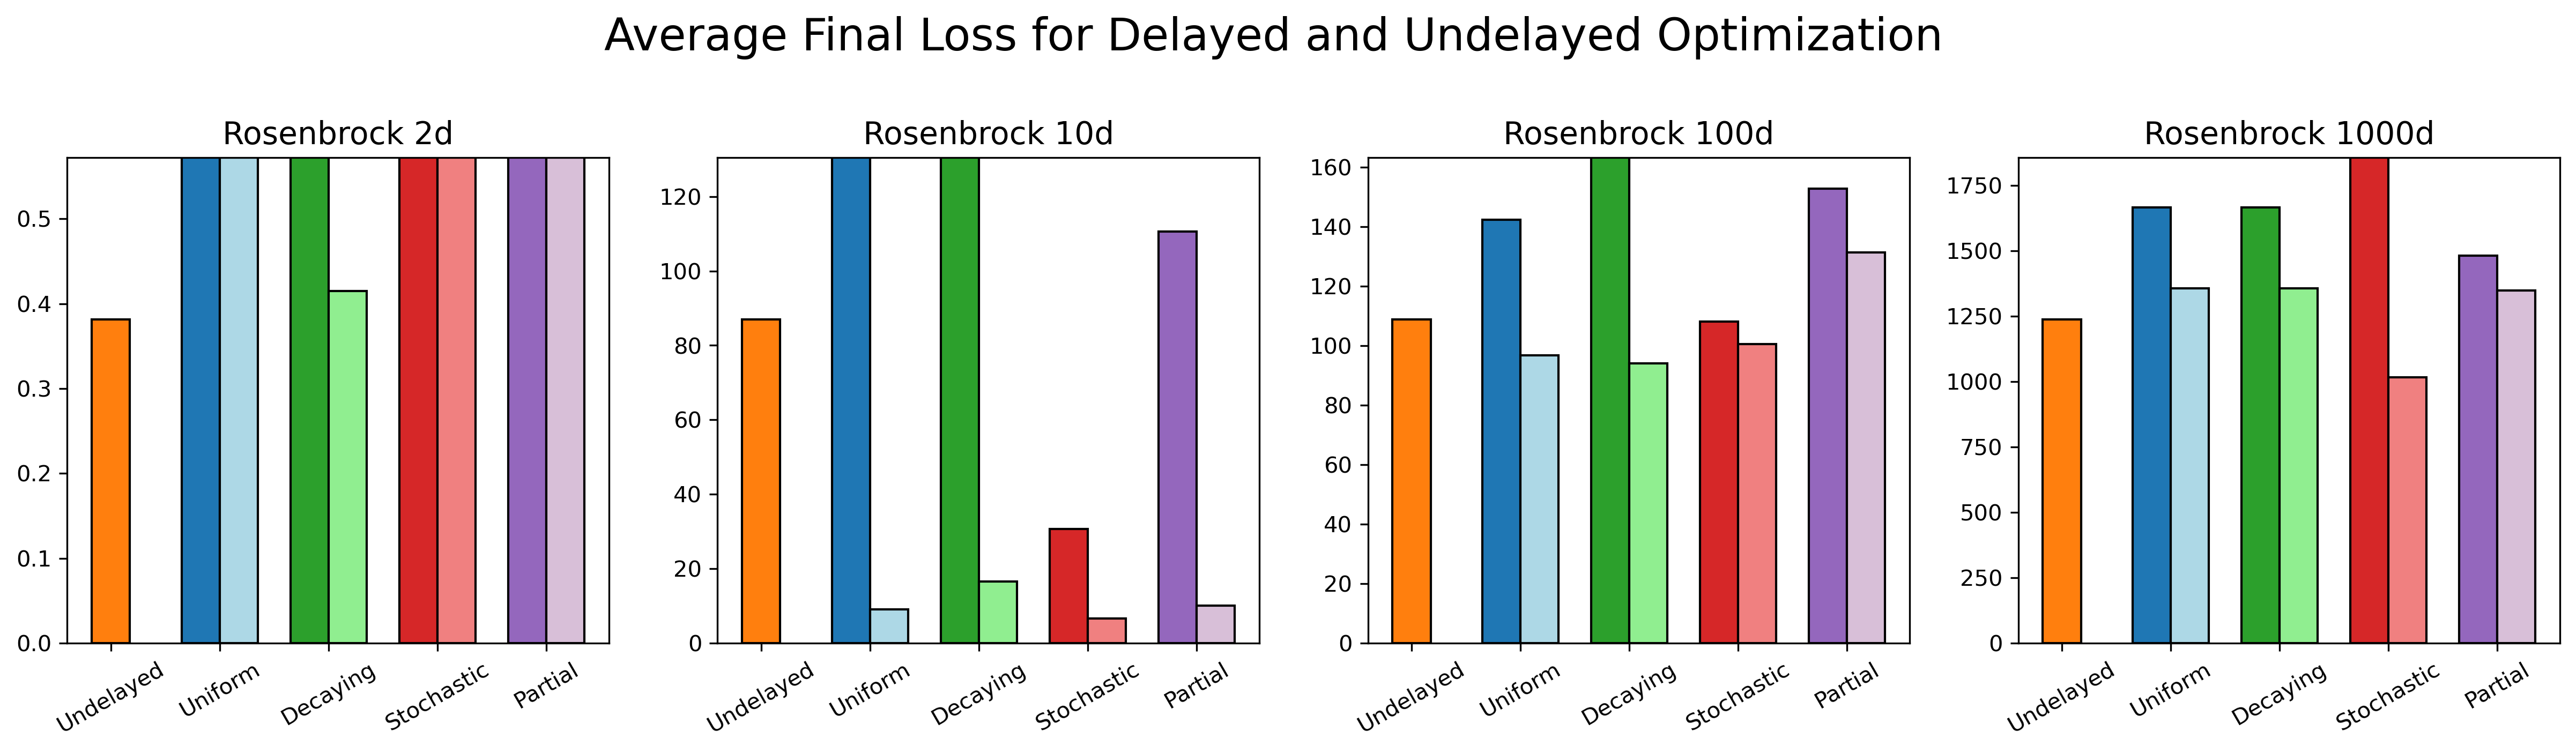

In [21]:
file_tags = ["optimal_undel", "optimal_stoch"]
plot_bar("Ackley", file_tags, delay_names=["Undelayed", "Stochastic"])

## Zakharov

In [3]:
file_tags = ["optimal_undel", "optimal_stoch"]
plot_bar("Ackley", file_tags, delay_names=["Undelayed", "Stochastic"])

NameError: name 'bar_chart' is not defined